# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [212]:
# Code Here
import pandas as pd
import numpy as np
import random
from plotnine import *
from palmerpenguins import load_penguins
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set seed for reproducibility
np.random.seed(123)
random.seed(123)

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [213]:
# Load dataset
df = load_penguins()

# Drop rows with missing values
df = df.dropna()
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [214]:
# Check Species Counts
df.species.value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

In [215]:
# Encode target variable `species` into numerical values for classification
df['species'] = df['species'].astype('category').cat.codes  # 0, 1, 2 for the three species
df.species.value_counts()

species
0    146
2    119
1     68
Name: count, dtype: int64

In [216]:
# Select features and target variable (species)
X = df.drop(columns=['species'])
y = df['species']

# Preprocess categorical and numerical features
categorical_features = ['island', 'sex', 'year']
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

In [217]:
# kNN model 1
knn1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=3))
])
knn1.fit(X_train, y_train)
y_pred_knn1 = knn1.predict(X_test)

# kNN model 2
knn2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])
knn2.fit(X_train, y_train)
y_pred_knn2 = knn2.predict(X_test)

# Decision Tree model 1
tree1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=3))
])
tree1.fit(X_train, y_train)
y_pred_tree1 = tree1.predict(X_test)

# Decision Tree model 2
tree2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5))
])
tree2.fit(X_train, y_train)
y_pred_tree2 = tree2.predict(X_test)

In [218]:
# Binarize the target variable for one-vs-rest evaluation (required for AUC calculation)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
species_names = ['Adelie', 'Chinstrap', 'Gentoo']

def evaluate_classification_model(model, model_name, X_test, y_test, y_test_binarized):
    # Predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Confusion Matrix
    print(f"\nConfusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_pred))
    
    # Overall Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy for {model_name}: {accuracy:.2f}")
    
    # Precision, Recall, F1-Score, and AUC (One-vs-All for each species)
    for idx, species in enumerate(species_names):
        print(f"\nMetrics for {species} (One-vs-Rest using {model_name}):")
        
        # Precision, Recall, F1-Score (one-vs-all evaluation)
        precision = precision_score(y_test, y_pred, labels=[idx], average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, labels=[idx], average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, labels=[idx], average='weighted', zero_division=0)
        
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1-score: {f1:.2f}")
        
        # AUC Score
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test_binarized[:, idx], y_proba[:, idx])
            roc_auc = auc(fpr, tpr)
            print(f"AUC: {roc_auc:.2f}")

# Evaluate models
evaluate_classification_model(knn1, "kNN (k=3)", X_test, y_test, y_test_binarized)
evaluate_classification_model(knn2, "kNN (k=5)", X_test, y_test, y_test_binarized)
evaluate_classification_model(tree1, "Decision Tree (max_depth=3)", X_test, y_test, y_test_binarized)
evaluate_classification_model(tree2, "Decision Tree (max_depth=5)", X_test, y_test, y_test_binarized)


Confusion Matrix for kNN (k=3):
[[43  1  0]
 [ 0 20  0]
 [ 0  0 36]]
Overall Accuracy for kNN (k=3): 0.99

Metrics for Adelie (One-vs-Rest using kNN (k=3)):
Precision: 1.00
Recall: 0.98
F1-score: 0.99
AUC: 1.00

Metrics for Chinstrap (One-vs-Rest using kNN (k=3)):
Precision: 0.95
Recall: 1.00
F1-score: 0.98
AUC: 1.00

Metrics for Gentoo (One-vs-Rest using kNN (k=3)):
Precision: 1.00
Recall: 1.00
F1-score: 1.00
AUC: 1.00

Confusion Matrix for kNN (k=5):
[[43  1  0]
 [ 0 20  0]
 [ 0  0 36]]
Overall Accuracy for kNN (k=5): 0.99

Metrics for Adelie (One-vs-Rest using kNN (k=5)):
Precision: 1.00
Recall: 0.98
F1-score: 0.99
AUC: 1.00

Metrics for Chinstrap (One-vs-Rest using kNN (k=5)):
Precision: 0.95
Recall: 1.00
F1-score: 0.98
AUC: 1.00

Metrics for Gentoo (One-vs-Rest using kNN (k=5)):
Precision: 1.00
Recall: 1.00
F1-score: 1.00
AUC: 1.00

Confusion Matrix for Decision Tree (max_depth=3):
[[41  2  1]
 [ 1 19  0]
 [ 0  1 35]]
Overall Accuracy for Decision Tree (max_depth=3): 0.95

Metric

 The k-Nearest Neighbors (kNN) models, with k=3 and k=5, demonstrated near-perfect classification performance, achieving an overall accuracy of 0.99. Both models showed excellent Precision, Recall, and F1-scores across all species, with an AUC of 1.00 for each class, indicating flawless discrimination between positive and negative cases for Adelie, Chinstrap, and Gentoo. Similarly, the Decision Tree models, using depths of 3 and 5, achieved strong performance, with overall accuracies of 0.95 and 0.96, respectively. However, these models exhibited slightly more misclassifications compared to kNN, particularly for the Adelie and Chinstrap classes. Precision for Chinstrap was notably lower for the Decision Tree models, which could be attributed to its smaller representation in the dataset. The consistently high performance across models suggests that the features effectively distinguish between the species, though the near-perfect metrics for some models raise the possibility of overfitting. To ensure the models' robustness and generalizability, further validation using cross-validation and potential hyperparameter tuning is recommended.

In [219]:
# Compute ROC and AUC for Adelie for all models
roc_data = []

for model, model_name in [(knn1, "kNN (k=3)"), 
                          (knn2, "kNN (k=5)"), 
                          (tree1, "Decision Tree (max_depth=3)"), 
                          (tree2, "Decision Tree (max_depth=5)")]:
    y_proba = model.predict_proba(X_test)
    if y_proba is not None:
        # Calculate ROC curve for Adelie at index 0
        fpr, tpr, _ = roc_curve(y_test_binarized[:, 0], y_proba[:, 0])
        roc_auc = auc(fpr, tpr)
        roc_data.append(pd.DataFrame({
            'False Positive Rate': fpr,
            'True Positive Rate': tpr,
            'Model': [model_name] * len(fpr),
            'AUC': [roc_auc] * len(fpr)
        }))

# Combine all ROC data into a single DataFrame
roc_df = pd.concat(roc_data)

roc_df.head()

,False Positive Rate,True Positive Rate,Model,AUC
0,0.000000,0.000000,kNN (k=3),0.999797
1,0.000000,0.977273,kNN (k=3),0.999797
2,0.017857,1.000000,kNN (k=3),0.999797
3,1.000000,1.000000,kNN (k=3),0.999797
0,0.000000,0.000000,kNN (k=5),1.000000


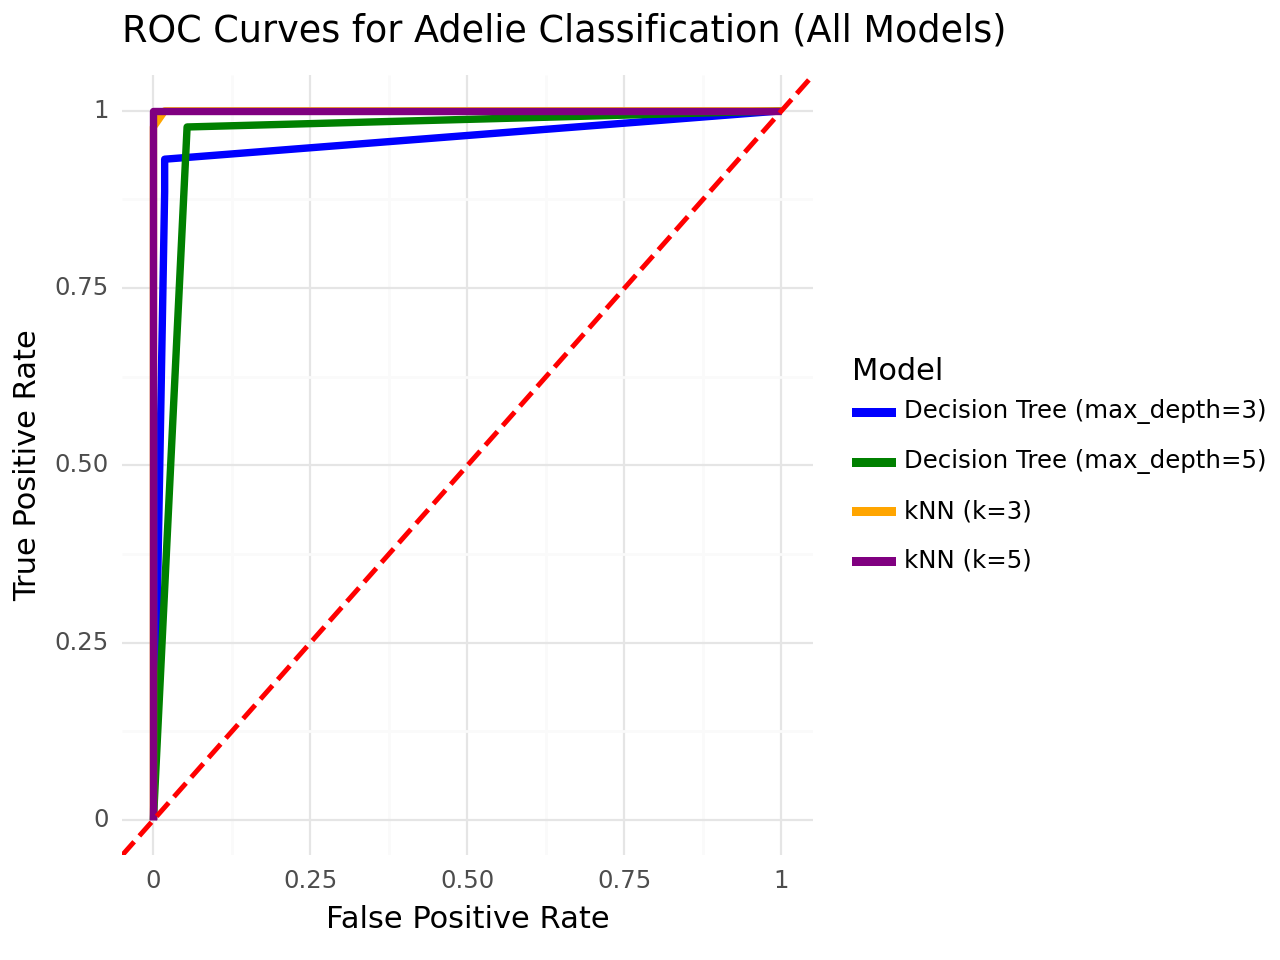

<Figure Size: (640 x 480)>

In [220]:
# Create ROC plot 
roc_plot = (
    ggplot(roc_df, aes(x='False Positive Rate', y='True Positive Rate', color='Model')) +
    geom_line(size=1.5) +
    geom_abline(intercept=0, slope=1, linetype='dashed', color='red', size=1) +  # Random classifier line
    labs(
        title='ROC Curve for Adelie Classification (Multiple Models)',
        x='False Positive Rate',
        y='True Positive Rate',
        color='Model'
    ) +
    ggtitle('ROC Curves for Adelie Classification (All Models)') +
    theme_minimal() +
    scale_color_manual(values=['blue', 'green', 'orange', 'purple'])  # Customize colors as desired
)

roc_plot

 The ROC curves for the Adelie classification, generated across multiple models (kNN and Decision Trees), illustrate near-perfect classification performance. All models achieve high true positive rates with minimal false positives, as indicated by the curves' proximity to the top-left corner of the plot. The curves' sharp rise reflects the models' ability to quickly maximize the true positive rate while maintaining a low false positive rate. The close alignment of the curves across different models suggests consistent performance, indicating that the dataset's features enable effective separation of the Adelie class. The red dashed diagonal line represents the "random classifier" baseline, and the distance between the models' curves and this line further emphasizes their strong discriminatory power. This performance, while impressive, may warrant further validation to ensure generalizability and rule out potential overfitting.

Sources:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a